In [33]:
from keras.models import Sequential, Model, load_model
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, BatchNormalization, \
    Input
from keras.engine.topology import merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.applications.resnet50 import ResNet50
import pickle as pkl
import matplotlib.pyplot as plt
# from keras.utils.visualize_util import plot
import os
%matplotlib inline

In [2]:
# load data
Xtrain = np.load('./data/dataset256/Xtrain.npy')
Xtest = np.load('./data/dataset256/Xtest.npy')
Ytrain_reg = np.load('./data/dataset256/Ytrain_reg.npy')
Ytest_reg = np.load('./data/dataset256/Ytest_reg.npy')
Ytrain_cls = np.load('./data/dataset256/Ytrain_cls.npy')
Ytest_cls = np.load('./data/dataset256/Ytest_cls.npy')

In [31]:
print ('Xtrain', Xtrain.shape)
print ('Xtest', Xtest.shape)
print ('Ytrain_reg', Ytrain_reg.shape)
print ('Ytest_reg', Ytest_reg.shape)
print ('Ytrain_cls', Ytrain_cls.shape)
print ('Ytest_cls', Ytest_cls.shape)

Xtrain (15405, 256, 256, 3)
Xtest (3852, 256, 256, 3)
Ytrain_reg (15405,)
Ytest_reg (3852,)
Ytrain_cls (15405, 7)
Ytest_cls (3852, 7)


In [7]:
# netowrk settings

batch_size = 64
folder = './myresnet-training-checkpoint-new/'
if not os.path.exists(folder):
    os.makedirs(folder)

n_cls = int(np.max(Ytrain_cls))


In [8]:
Ytrain_cls = to_categorical(Ytrain_cls-1)
Ytest_cls = to_categorical(Ytest_cls-1)

In [34]:
def addResidualBlock(inp, size=(3,3), subsample=(4,4), filters_conv_rate=2, name=None):
    conv_filters = int(inp.get_shape()[-1])*filters_conv_rate
    inp = BatchNormalization()(inp)
    first = Convolution2D(conv_filters, size[0], size[1], border_mode='same', subsample=subsample, activation='relu')(inp)
    
    second = BatchNormalization()(first)
    second = Convolution2D(conv_filters, 3,3, border_mode='same', activation='relu')(second)
    
    second = BatchNormalization()(second)
    second = Convolution2D(conv_filters, 3,3, border_mode='same', activation='relu')(second)
    
    return merge([first, second], mode='sum', name=name)

In [35]:
def MyResNetRegr():
    inp = Input(shape=(256, 256,3))
    out = Convolution2D(16, 3,3, border_mode='same', activation='relu', subsample=(4,4))(inp)
    for i in range(3):
        out = addResidualBlock(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
    
    out = BatchNormalization()(out)
    out = Flatten()(out)
    out = Dense(128, activation='relu', name='fcc')(out)
    out = Dense(1, name='out')(out)
    
    model = Model(input=inp, output=out)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def MyResNetCls():
    inp = Input(shape=(256, 256,3))
    out = Convolution2D(16, 3,3, border_mode='same', activation='relu', subsample=(4,4))(inp)
    for i in range(3):
        out = addResidualBlock(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
    
    out = BatchNormalization()(out)
    out = Flatten()(out)
    out = Dense(128, activation='relu', name='fcc')(out)
    out = Dense(n_cls, activation='softmax', name='out')(out)
    
    model = Model(input=inp, output=out)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

def weighted_mse(y_true, y_pred, weight = 20.):
        err = mean_squared_error(y_true, y_pred)
        return err*weight
    
def MyResNet2Obj():
    inp = Input(shape=(256, 256,3))
    out = Convolution2D(16, 3,3, border_mode='same', activation='relu', subsample=(4,4))(inp)
    for i in range(3):
        out = addResidualBlock(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
    
    out = BatchNormalization()(out)
    out = Flatten()(out)
    out = Dense(128, activation='relu', name='fcc')(out)
    out_reg = Dense(1, name='out_reg')(out)
    out_cls = Dense(n_cls, activation='softmax', name='out_cls')(out)
    
    model = Model(input=inp, output=[out_reg, out_cls])
    mr = Model(input=inp, output=out_reg)
    mc = Model(input=inp, output=out_cls)

    model.compile(loss=['mean_squared_error', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    mr.compile(loss='mean_squared_error', optimizer='adam')
    mc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model, mr, mc


In [ ]:
load_path = False

In [12]:
load_path = './aaa_results/reg/checkpoint-99-0.00.hdf5'
if load_path:
    model_reg = load_model(load_path)
else:
    model_reg = MyResNetRegr()
# plot(model_reg, 'myresnet-training-checkpoint/reg_checkpoint/model.png')


In [15]:
load_path = './myresnet-training-checkpoint/cls_checkpoint/checkpoint-99-0.39.hdf5'
if load_path:
    model_cls = load_model(load_path)
else:
    model_cls = MyResNetCls()
# model_cls.summary()

In [37]:
load_path = False
# load_path = './aaa_results/2losse_normal/checkpoint-199-0.60.hdf5'
if load_path:
    model = load_model(load_path)
else:
    model, mr, mc = MyResNet2Obj()
model.summary()
# plot(model, 'myresnet-training-checkpoint/2obj_checkpoint/model.png', show_shapes=False, show_layer_names=False)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 64, 64, 16)    448         input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_14 (BatchNorm (None, 64, 64, 16)    64          convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 16, 16, 32)    4640        batchnormalization_14[0][0]      
___________________________________________________________________________________________

In [ ]:
if not os.path.exists(folder + '2obj_checkpoint/'):
    os.makedirs(folder + '2obj_checkpoint/')
checkpoint = ModelCheckpoint(filepath=folder + '2obj_checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5')
history = model.fit(x=Xtrain[:100], y=[Ytrain_reg[:100], Ytrain_cls[:100]], 
          nb_epoch=2, batch_size=batch_size,validation_split=0.1, verbose=1, callbacks=[checkpoint]) 
mr.save(folder + '2obj_checkpoint/model_reg.hdf5')
mc.save(folder + '2obj_checkpoint/model_cls.hdf5')
with open(folder + '2obj_checkpoint/history.pkl', 'wb') as f:
    pkl.dump(history.history, f)

In [ ]:
if not os.path.exists(folder + 'reg_checkpoint/'):
    os.makedirs(folder + 'reg_checkpoint/')
checkpoint = ModelCheckpoint(filepath=folder + '/reg_checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5')
history = model_reg.fit(x=Xtrain[:100], y=Ytrain_reg[:100], 
          nb_epoch=2, batch_size=batch_size,validation_split=0.1, verbose=1, callbacks=[checkpoint]) 
with open(folder + 'reg_checkpoint/history.pkl', 'wb') as f:
    pkl.dump(history.history, f)

In [ ]:
if not os.path.exists(folder + 'cls_checkpoint/'):
    os.makedirs(folder + 'cls_checkpoint/')
checkpoint = ModelCheckpoint(filepath=folder + '/cls_checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5')
history = model_cls.fit(x=Xtrain[:100], y=Ytrain_cls[:100], 
          nb_epoch=2, batch_size=batch_size,validation_split=0.1, verbose=1, callbacks=[checkpoint]) 
with open(folder + 'cls_checkpoint/history.pkl', 'wb') as f:
    pkl.dump(history.history, f)

In [9]:
evl_both = model.evaluate(x=Xtest, y=[Ytest_reg, Ytest_cls],batch_size=batch_size)

3852/3852 [==============================] - 14s    


In [13]:
evl_reg = model_reg.evaluate(x=Xtest, y=Ytest_reg,batch_size=batch_size)

3852/3852 [==============================] - 15s    


In [16]:
evl_cls = model_cls.evaluate(x=Xtest, y=Ytest_cls,batch_size=batch_size)

3852/3852 [==============================] - 14s    


In [10]:
model.metrics_names

['loss', 'out_reg_loss', 'out_cls_loss', 'out_reg_acc', 'out_cls_acc']

In [11]:
evl_both

[0.5623001135026926,
 0.0070894300903320343,
 0.55521068258572714,
 0.0,
 0.90238836973998404]

In [14]:
evl_reg

0.0023230025470718598

In [17]:
evl_cls

[0.40204537541509788, 0.91874350980311048]

In [25]:
with open('./aaa_results/2los-weighted/history.pkl', 'rb') as f:
    history = pkl.load(f) 

In [4]:
print(hitsory)

{'loss': [1.1123580733935039, 1.2439877324634128], 'val_loss': [45.657299041748047, 4.5590920448303223]}


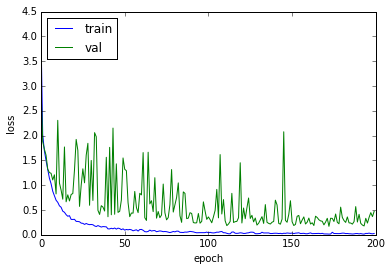

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# plt.plot(history['val_loss'])
# plt.plot(history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./aaa_results/reg/train.png')

In [27]:
model.metrics_names

['loss', 'out_reg_loss', 'out_cls_loss', 'out_reg_acc', 'out_cls_acc']

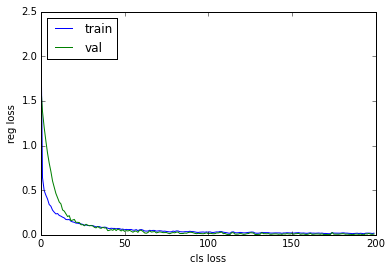

In [28]:
plt.plot(history['out_reg_loss'])
plt.plot(history['out_cls_loss'])
# plt.plot(history['val_loss'])
# plt.plot(history['val_loss'])

plt.ylabel('reg loss')
plt.xlabel('cls loss')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./aaa_results/reg/train.png')